In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np

/Users/sanskarmishra/apprazer/Apprazer/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Read the CSV file
file_path = 'year_2023_trimmed.csv'
df = pd.read_csv(file_path)  # Only read first 1000 rows

# # Let's start with a subset of columns for initial testing
# selected_columns = [
#     'loan_amount',
#     'income',
#     'property_value',
#     'debt_to_income_ratio', #monthly debt / monthly income
#     'derived_race',
#     'derived_sex',
#     'occupancy_type',
#     'loan_purpose',  # categorical features
#     'action_taken'   # target variable
# ]

# df = df[selected_columns]






/var/folders/1k/qjvp1x9d4c5c_kpdbfz9kk1h0000gn/T/ipykernel_15996/3240689177.py:3: DtypeWarning: Columns (5,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)  # Only read first 1000 rows


In [3]:
df = df.dropna()

# --- (1) Filter out unwanted action_taken classes ---
valid_actions = [1, 2, 3, 6]
df = df[df['action_taken'].isin(valid_actions)]

not_available_race = ['Race Not Available']

not_available_sex = ['Sex Not Available']

df = df[~df['derived_race'].isin(not_available_race) & ~df['derived_sex'].isin(not_available_sex)]



# Remap values: 1,2,6 -> 1; 3 -> 0
mapping = {1: 1, 2: 1, 6: 1, 3: 0}

dti_mapping = {
    '<20%': .10,
    '20%-<30%': .25,
    '30%-<36%': .33,
    '36': .36,
    '37': .37,
    '38': .38,
    '39': .39,
    '40': .40,
    '41': .41,
    '42': .42,
    '43': .43,
    '44': .44,
    '45': .45,
    '46': .46,
    '47': .47,
    '48': .48,
    '49': .49,
    '50%-60%' : .55,
    '>60%': .80,   
}


df['action_taken'] = df['action_taken'].map(mapping)

df['debt_to_income_ratio'] = df['debt_to_income_ratio'].map(dti_mapping)


# Handle missing values and non-numeric values in numerical columns
for col in ['loan_amount', 'income', 'property_value']:
    # Convert non-numeric values to NaN
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna()

# Drop rows with any NaN values
df.to_csv('data.csv', index=False)
print("Dataset shape after cleaning:", df.shape)


Dataset shape after cleaning: (6034574, 9)


In [4]:
data = pd.read_csv('data.csv')
df = data.sample(frac = .005, random_state=42)

# smaller.to_csv('small_2023_sample.csv', index= False)

# --- (2) Check how many rows remain and distribution ---
print("Dataset shape after filtering classes:", df.shape)
print("\nDistribution of action_taken (1=Approved,0=Denied):")
print(df['action_taken'].value_counts())
# Print basic info about the loaded data
print("Dataset shape:", df.shape)
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape after filtering classes: (30173, 9)

Distribution of action_taken (1=Approved,0=Denied):
action_taken
1    23074
0     7099
Name: count, dtype: int64
Dataset shape: (30173, 9)

Missing values:
derived_race            0
derived_sex             0
action_taken            0
loan_purpose            0
loan_amount             0
property_value          0
occupancy_type          0
income                  0
debt_to_income_ratio    0
dtype: int64


In [5]:
# df_yes = df[df['action_taken'] == 1]

# df_yes = df_yes.sample(frac=0.5, random_state= 42)

# df_no = df[df['action_taken'] == 0]

# df = pd.concat([df_yes, df_no])

# df = df.sample(frac = 1).reset_index(drop=True)

# print(df)

In [6]:


# After cleaning but before encoding, add these prints:
print("\nDistribution of action_taken values:")
print(df['action_taken'].value_counts())
print("\nPercentage distribution:")
print(df['action_taken'].value_counts(normalize=True) * 100)

# Separate features and target
X = df.drop('action_taken', axis=1)
y = df['action_taken']


Distribution of action_taken values:
action_taken
1    23074
0     7099
Name: count, dtype: int64

Percentage distribution:
action_taken
1    76.472343
0    23.527657
Name: proportion, dtype: float64


In [7]:
# Split categorical and numerical columns
categorical_columns = ['derived_race', 'derived_sex', 'occupancy_type', 'loan_purpose']
numerical_columns = ['loan_amount', 'income', 'property_value', 'debt_to_income_ratio']

# Initialize encoders
label_encoders = {}
X_encoded = X.copy()

# Encode categorical variables
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    X_encoded[col] = label_encoders[col].fit_transform(X[col])

# Scale numerical variables
scaler = StandardScaler()
X_encoded[numerical_columns] = scaler.fit_transform(X_encoded[numerical_columns])

# Remap the target values to 0, 1, 2
label_encoder_y = LabelEncoder()
y = label_encoder_y.fit_transform(y)


In [8]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [9]:
print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("\nSample of encoded features:")
print(X_encoded.head())
print("\nUnique values in target variable:", np.unique(y))

# After data cleaning but before model creation, add these debug prints:
print("\nUnique values in target variable:", np.unique(y))
print("Number of unique classes:", len(np.unique(y)))
print("Min value in action_taken:", y.min())
print("Max value in action_taken:", y.max())


Training set shape: (24138, 8)
Test set shape: (6035, 8)

Sample of encoded features:
         derived_race  derived_sex  loan_purpose  loan_amount  property_value  \
1021141             7            0             1    -0.764634       -0.247763   
2152869             2            2             0     1.247769        0.348452   
2905982             3            0             1    -0.764634       -0.512747   
3872650             7            0             0    -0.391967       -0.380255   
4204532             5            1             0     0.726035        0.215960   

         occupancy_type    income  debt_to_income_ratio  
1021141               0 -0.138333              0.496757  
2152869               0  0.014684             -0.506894  
2905982               0 -0.104329             -1.008720  
3872650               0 -0.155335              0.308572  
4204532               0 -0.032398             -0.506894  

Unique values in target variable: [0 1]

Unique values in target variable: [0

In [10]:
# Import TabTransformer
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping

# Define model parameters
num_numerical_features = len(numerical_columns)
num_categorical_features = len(categorical_columns)
num_classes = len(np.unique(y))  # Fixed: using np.unique instead of .unique()

categorical_cardinalities = [
    len(label_encoders[col].classes_) for col in categorical_columns
]

In [11]:
print("Model configuration:")
print(f"Number of numerical features: {num_numerical_features}")
print(f"Number of categorical features: {num_categorical_features}")
print(f"Categorical cardinalities: {categorical_cardinalities}")
print(f"Number of classes: {num_classes}")

Model configuration:
Number of numerical features: 4
Number of categorical features: 4
Categorical cardinalities: [8, 3, 3, 6]
Number of classes: 2


In [12]:
def create_tab_transformer(
    num_numerical_features,
    categorical_cardinalities,
    num_classes,
    d_model=32,
    num_heads=8,
    num_transformer_blocks=6,
    mlp_dropout=0.1,
    transformer_dropout=0.1
):
    # Numerical features
    numerical_inputs = keras.Input(shape=(num_numerical_features,))
    numerical_features = layers.BatchNormalization()(numerical_inputs)
    numerical_features = layers.Dense(d_model)(numerical_features)

    # Categorical features
    categorical_inputs = []
    categorical_embeddings = []
    
    for cardinality in categorical_cardinalities:
        input_layer = keras.Input(shape=(1,))
        categorical_inputs.append(input_layer)
        
        embedding_layer = layers.Embedding(
            input_dim=cardinality,
            output_dim=d_model
        )(input_layer)
        embedding_layer = layers.Reshape((-1, d_model))(embedding_layer)
        categorical_embeddings.append(embedding_layer)

    # Concatenate categorical embeddings
    if categorical_embeddings:
        categorical_features = layers.Concatenate(axis=1)(categorical_embeddings)
        
        # Add positional embeddings
        categorical_features = layers.LayerNormalization(epsilon=1e-6)(categorical_features)
    
        # Apply Transformer blocks
        for _ in range(num_transformer_blocks):
            # Multi-head self attention
            attention_output = layers.MultiHeadAttention(
                num_heads=num_heads,
                key_dim=d_model,
                dropout=transformer_dropout
            )(categorical_features, categorical_features)
            
            # Skip connection 1
            x1 = layers.Add()([attention_output, categorical_features])
            x1 = layers.LayerNormalization(epsilon=1e-6)(x1)
            
            # Feed-forward network
            x2 = layers.Dense(d_model * 4, activation="relu")(x1)
            x2 = layers.Dropout(mlp_dropout)(x2)
            x2 = layers.Dense(d_model)(x2)
            
            # Skip connection 2
            categorical_features = layers.Add()([x2, x1])
            categorical_features = layers.LayerNormalization(epsilon=1e-6)(categorical_features)
        
        # Pool categorical features
        categorical_features = layers.GlobalAveragePooling1D()(categorical_features)

    # Combine features
    features = layers.Concatenate(axis=1)([
        numerical_features,
        categorical_features
    ])

    # Final MLP layers
    features = layers.Dense(64, activation="relu")(features)
    features = layers.Dropout(mlp_dropout)(features)
    features = layers.Dense(32, activation="relu")(features)
    features = layers.Dropout(mlp_dropout)(features)
    
    # Output layer
    output = layers.Dense(num_classes, activation="softmax")(features)

    # Create model
    model = keras.Model(
        inputs=[numerical_inputs] + categorical_inputs,
        outputs=output
    )
    
    return model

In [13]:
# Create the model
model = create_tab_transformer(
    num_numerical_features=num_numerical_features,
    categorical_cardinalities=categorical_cardinalities,
    num_classes=num_classes
)

# print("\nModel Summary:")
# model.summary()

# Prepare data in the format needed for the model
X_train_numerical = X_train[numerical_columns].values
X_test_numerical = X_test[numerical_columns].values

X_train_categorical = [X_train[col].values.reshape(-1, 1) for col in categorical_columns]
X_test_categorical = [X_test[col].values.reshape(-1, 1) for col in categorical_columns]

# Convert target to one-hot encoded format
y_train_encoded = keras.utils.to_categorical(y_train)
y_test_encoded = keras.utils.to_categorical(y_test)

# print("\nUnique values in encoded target:", np.unique(y))
# print("Shape of encoded training target:", y_train_encoded.shape)
# print("Shape of encoded test target:", y_test_encoded.shape)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping

# Suppose y_train is an array of shape [n_samples]
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print("Computed class weights:", class_weights_dict)

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    [X_train_numerical] + X_train_categorical,
    y_train_encoded,
    validation_data=([X_test_numerical] + X_test_categorical, y_test_encoded),
    class_weight=class_weights_dict,    # <-- balances classes
    batch_size=128,                     # a moderate batch size
    epochs=50,                          # more epochs
    callbacks=[early_stop],             # early stopping
    verbose=1
)

# Print final evaluation
test_loss, test_accuracy = model.evaluate(
    [X_test_numerical] + X_test_categorical,
    y_test_encoded,
    verbose=0
)
print(f"\nTest accuracy: {test_accuracy:.4f}")

Computed class weights: {0: np.float64(2.1312025428218258), 1: np.float64(0.6532611637347767)}
Epoch 1/50
 23/189 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.6646 - loss: 0.6366

189/189 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.7197 - loss: 0.5739 - val_accuracy: 0.8131 - val_loss: 0.4518
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.7508 - loss: 0.5259 - val_accuracy: 0.8015 - val_loss: 0.4681
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.7506 - loss: 0.5183 - val_accuracy: 0.7816 - val_loss: 0.4810
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.7641 - loss: 0.5136 - val_accuracy: 0.8031 - val_loss: 0.4670
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.7677 - loss: 0.5110 - val_accuracy: 0.8075 - val_loss: 0.4470
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.7721 - loss: 0.5064 - val_accuracy: 0.7993 - val_loss: 0.4731
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.7658 - loss: 0.5135 - val_accuracy: 0.7795 - val_loss: 0.5040
Epoch 8/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.7698 - loss: 0.5076 - val_accurac

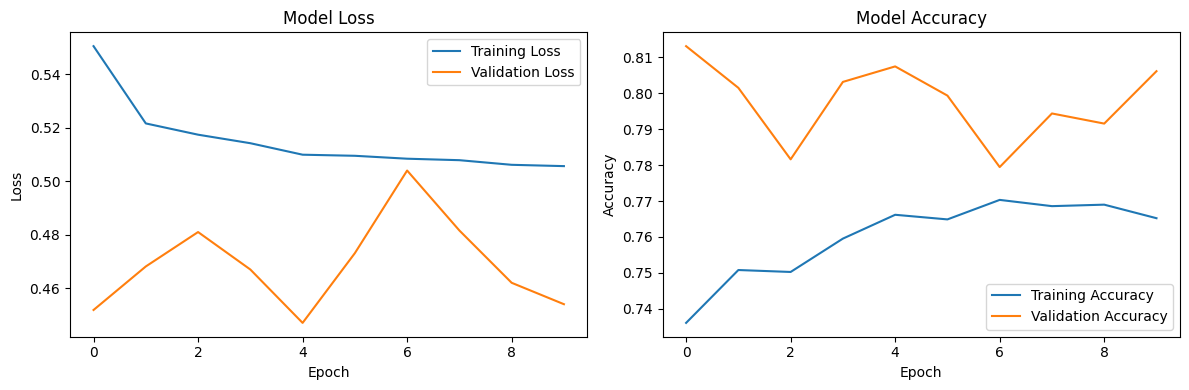

In [15]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()